In [19]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
import maxint_opt as opt

In [20]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

In [21]:
DIM = 3
LSCALE = 1.0
SDIM = 2
ADIM = 1
BETA = 2.0
ABOUNDS = [-5.0,5.0]
SBOUNDS = [-5.0,5.0]

In [22]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=LSCALE)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m,x

x_range = np.array([[-5.0,-5.0,-5.0], [5.0,5.0,5.0]])
f,m,x = sample_function(x_range)


In [23]:
x = np.random.uniform(x_range[0], x_range[1], (1, DIM))
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=DIM,lengthscale=LSCALE),noise_var=0.0)
gps = [gp]

In [24]:
x = np.array([[0.3,0.3,0.3]])
u,v = gp.predict(x)
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

print get_mean_func(gp)(x)
print get_cov_func(gp)(x,x)

[[-0.04149415]] [[0.99949829]]
[[-0.04149415]]
[[0.99949829]]


In [25]:
# b = np.array([0.0])
# B = np.array([[1.0]])
b = np.zeros(SDIM)
B = I = np.identity(SDIM)
gps = opt.OPT(f,gp,b,B,SDIM,ADIM,50,ABOUNDS,SBOUNDS,BETA,LSCALE)

iter 0
[4.99909614]
[[0.28156083]]
iter 1
[3.08932602]
[[1.43951621]]
iter 2
[2.19770666]
[[0.67545832]]
iter 3
[3.62192776]
[[1.20869985]]
iter 4
[3.67046063]
[[0.8466046]]
iter 5
[3.04142009]
[[-0.02025206]]
iter 6
[2.98344583]
[[0.66814869]]
iter 7
[-4.99715065]
[[-0.13718046]]
iter 8
[0.12053656]
[[-0.26298287]]
iter 9
[2.95678855]
[[-0.20755029]]
iter 10
[3.7449484]
[[0.19787682]]
iter 11
[3.11174313]
[[1.0524331]]
iter 12
[3.57405752]
[[0.75935798]]
iter 13
[3.40923913]
[[-0.1475056]]
iter 14
[3.34746928]
[[-0.25728416]]
iter 15
[3.16338538]
[[0.61348573]]
iter 16
[3.32505725]
[[-0.06174904]]
iter 17
[3.42827233]
[[-1.12640311]]
iter 18
[2.8302851]
[[-0.06716505]]
iter 19
[3.31036731]
[[0.11371227]]
iter 20
[3.32596646]
[[0.01203495]]
iter 21
[-4.0009739]
[[-0.53938945]]
iter 22
[3.31018026]
[[0.18512512]]
iter 23
[3.31563869]
[[1.24742235]]
iter 24
[3.34598055]
[[0.71750837]]
iter 25
[2.91851714]
[[0.30372992]]
iter 26
[3.30109888]
[[0.05722481]]
iter 27
[3.28847687]
[[0.3820894

In [ ]:
gps[-1].X.shape

REFERENCE


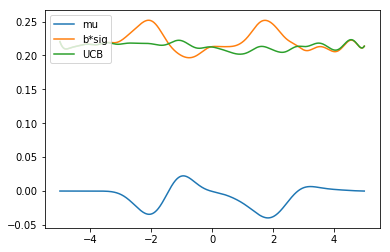

In [184]:
print "REFERENCE"
actions = np.linspace(-5.0,5.0,1000)
INDEX = -1
def plot_reference(m,actions):
    mus = []
    var = []
    tot = []
    for a in actions:
        out = integrate_dim(m,SDIM, a, b,B)
        mus.append(out[0])
        var.append(BETA*np.sqrt(out[1]))
        tot.append(out[0] + BETA*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
    
    
    
plot_reference(gps[-1],actions)

# plot_reference(m,actions)

3.253253253253254 0.6653157687521469
3.253253253253254 0.6674713293731442


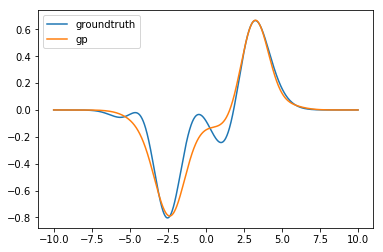

In [26]:
actions = np.linspace(-10.0,10.0,1000)

def plot_errors(m,gps):
    mus1 = []
    mus2 = []
    for a in actions:
        out1 = opt.integrate_dim(m, SDIM, a, b,B)
        mus1.append(out1[0])
    for i, gp in enumerate(gps):
        mus2 = []
        for a in actions:
            out2 = opt.integrate_dim(gp, SDIM, a, b,B)
            mus2.append(out2[0])
        plt.clf()
        plt.title("Integral Estimate - 3 Sdim - 1 Adim -Iteration %d" % i)
        plt.plot(actions, mus1, 'r', lw=2)
        plt.plot(actions, mus2, 'b', lw=2)
        plt.ylabel('integral of f(s,a)ds')
        plt.xlabel('actions')
        plt.savefig("./imgs/%i.png" % i)

INDEX = -1
def plot_error(m,gp):
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,opt.integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,opt.integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, mus,label='groundtruth')
    plt.plot(actions, preds,label='gp')
    plt.legend(loc='upper left')
    plt.show()
plot_error(m,gps[-1])
# plot_errors(m,gps)

[ 0.93252002 -3.08746779] 0.4261793495890401
[ 0.93252002 -3.08746779] 0.40304933998082754


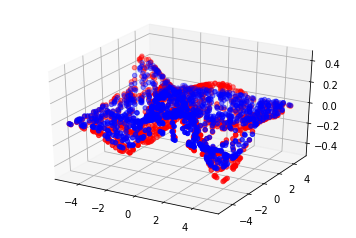

In [10]:
actions = np.random.uniform(ABOUNDS[0],ABOUNDS[1], (1000, ADIM))

def plot_3d(m,gp):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,opt.integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,opt.integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    ax.scatter(actions[:,0], actions[:,1], mus,c='r')
    ax.scatter(actions[:,0], actions[:,1], preds,c='b')
    plt.show()
plot_3d(m,gps[-1])

In [11]:
len(gps)

100

In [38]:
np.append(a,10.0)

array([ 2., 10.])